In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [3]:
from dask.distributed import Client

# for virga
client = Client(n_workers=28, threads_per_worker=2, processes=True)

client

<Client: 'tcp://127.0.0.1:34567' processes=28 threads=56, memory=1.48 TiB>

In [4]:
epoch_key = 'Jaq', 3, 12

In [5]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

01-Nov-21 17:01:39 Loading position info...
01-Nov-21 17:02:33 Loading multiunit...
01-Nov-21 17:02:57 Loading spikes...
01-Nov-21 17:04:13 Finding ripple times...


In [6]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 8.0,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])},
    'multiunit_occupancy_kwargs': {'bandwidth': np.array([8.0])},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.00003, 0.968])
}

In [7]:
from replay_identification import ReplayDetector

replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

01-Nov-21 17:04:56 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mo...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spik

In [8]:
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING


EDGE_ORDER = [0, 1, 3, 2, 4]

replay_detector.fit(
    is_ripple=data['is_ripple'],
    is_training=data['position_info'].nose_vel > 4,
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    center_well_id=0,
    edge_order=EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING,
)

01-Nov-21 17:04:56 Fitting speed model...
01-Nov-21 17:04:58 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 17:15:24 Fitting replay movement state transition...
01-Nov-21 17:15:25 Fitting replay state transition...


ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mo...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty=0.5

In [9]:
detector_results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_smoother=True)

detector_results

01-Nov-21 17:15:25 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 17:16:46 Finding causal replay probability and position...
01-Nov-21 17:16:59 Finding acausal replay probability and position...


<xarray.Dataset>
Dimensions:             (time: 448713, state: 2, position: 161)
Coordinates:
  * time                (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position            (position) float64 1.249 3.747 6.246 ... 419.9 422.4
  * state               (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 4.367e-10
    likelihood          (time, state, position) float64 9.428e-105 ... 1.0
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 4.367e-10
    replay_probability  (time) float64 0.0 0.001816 0.00602 ... 0.9978 0.9659

In [10]:
replay_detector2 = ReplayDetector(**detector_parameters)
logging.info(replay_detector2)

01-Nov-21 17:17:36 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mo...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spik

In [11]:
replay_detector2.fit(
    is_ripple=detector_results.replay_probability > 0.8,
    is_training=detector_results.replay_probability <= 0.8,
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    center_well_id=0,
    edge_order=EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING,
)

01-Nov-21 17:17:36 Fitting speed model...
01-Nov-21 17:17:38 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 17:36:29 Fitting replay movement state transition...
01-Nov-21 17:36:29 Fitting replay state transition...


ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mo...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty=0.5

In [12]:
detector_results2 = replay_detector2.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_smoother=True)

01-Nov-21 17:36:29 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 17:37:50 Finding causal replay probability and position...
01-Nov-21 17:37:59 Finding acausal replay probability and position...


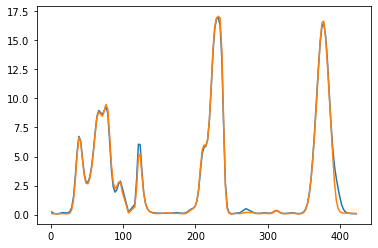

In [13]:
import matplotlib.pyplot as plt


place_conditional_intensity = (
    replay_detector._spiking_likelihood
    .keywords['place_conditional_intensity']).squeeze()
place_conditional_intensity2 = (
    replay_detector2._spiking_likelihood
    .keywords['place_conditional_intensity']).squeeze()

neuron_ind = 21
plt.plot(replay_detector.place_bin_centers_, place_conditional_intensity[:, neuron_ind] * 500)
plt.plot(replay_detector2.place_bin_centers_, place_conditional_intensity2[:, neuron_ind] * 500)

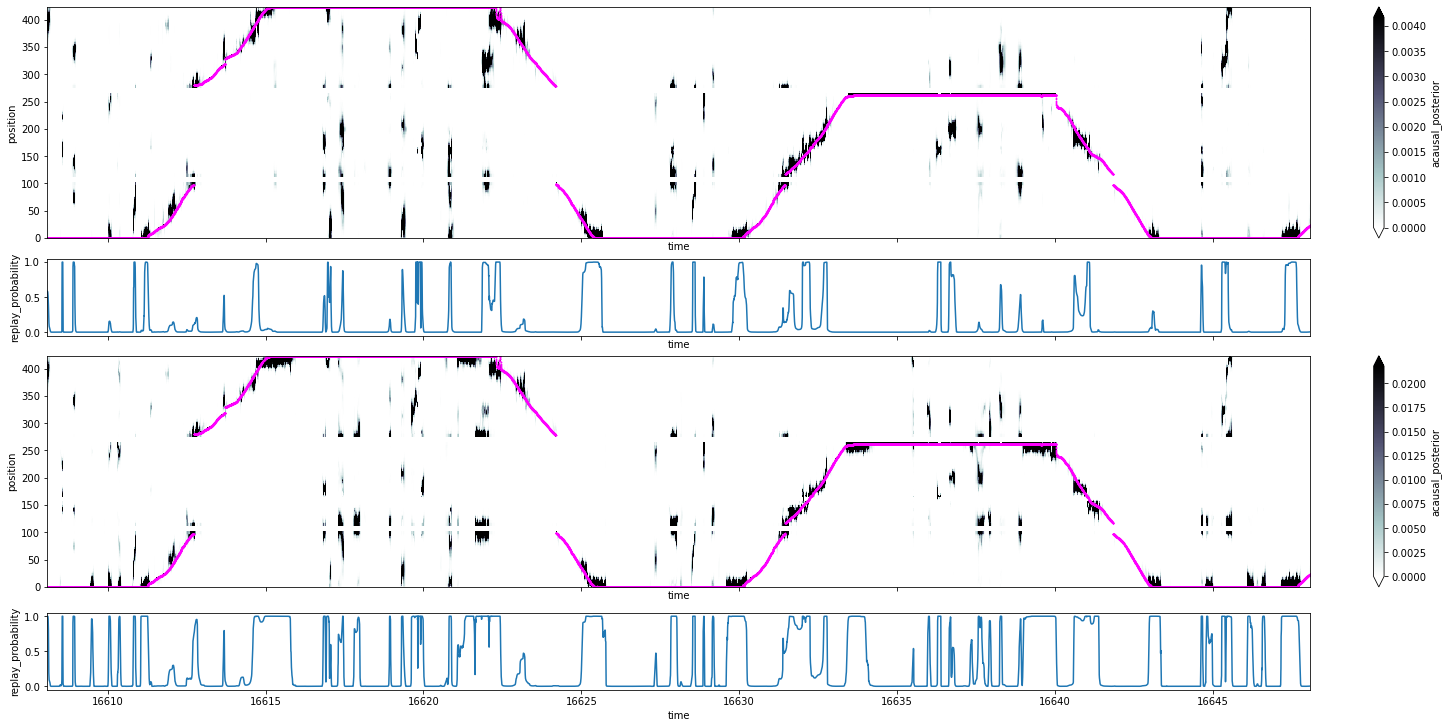

In [14]:
time_slice = slice(120_000, 140_000)

fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1, 3, 1]})
detector_results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[0])
axes[0].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[1])

detector_results2.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[2])
axes[2].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results2.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[3])

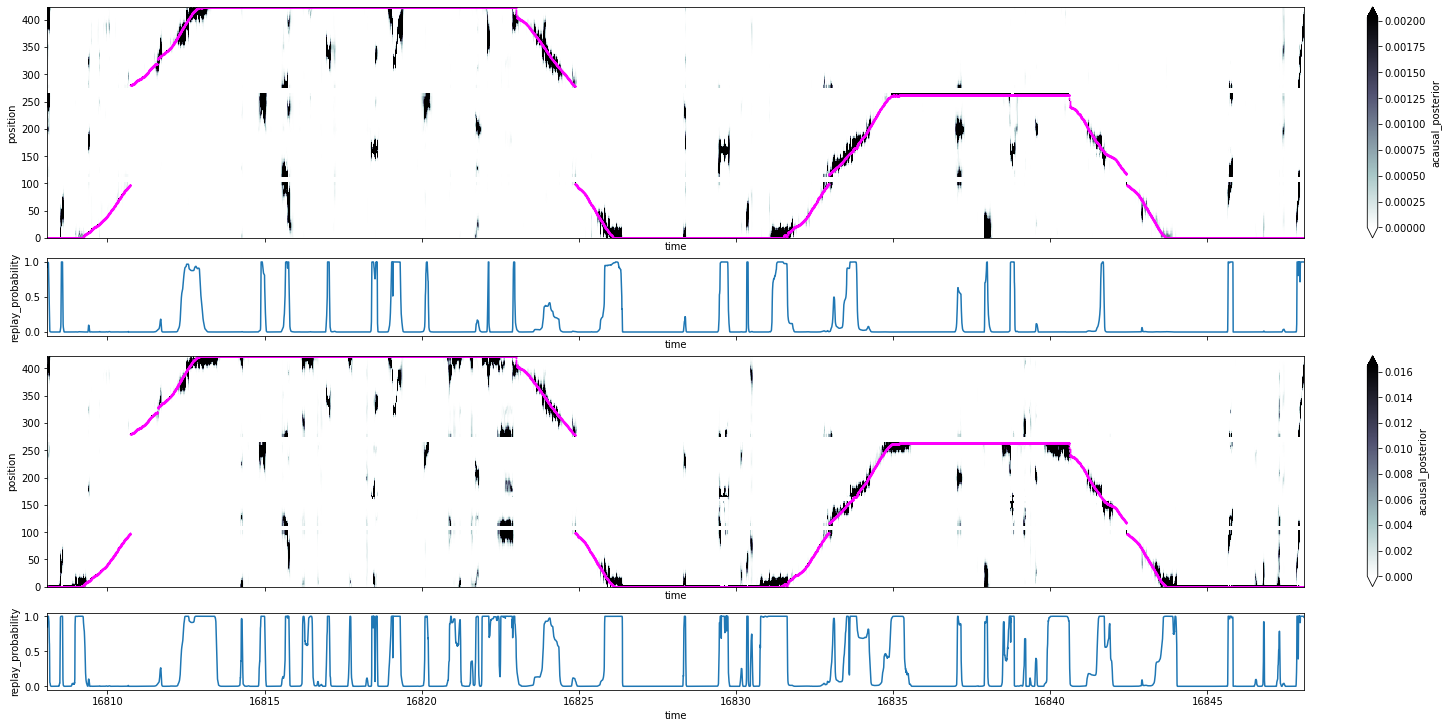

In [15]:
import matplotlib.pyplot as plt

time_slice = slice(220_000, 240_000)

fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1, 3, 1]})
detector_results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[0])
axes[0].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[1])

detector_results2.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[2])
axes[2].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results2.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[3])

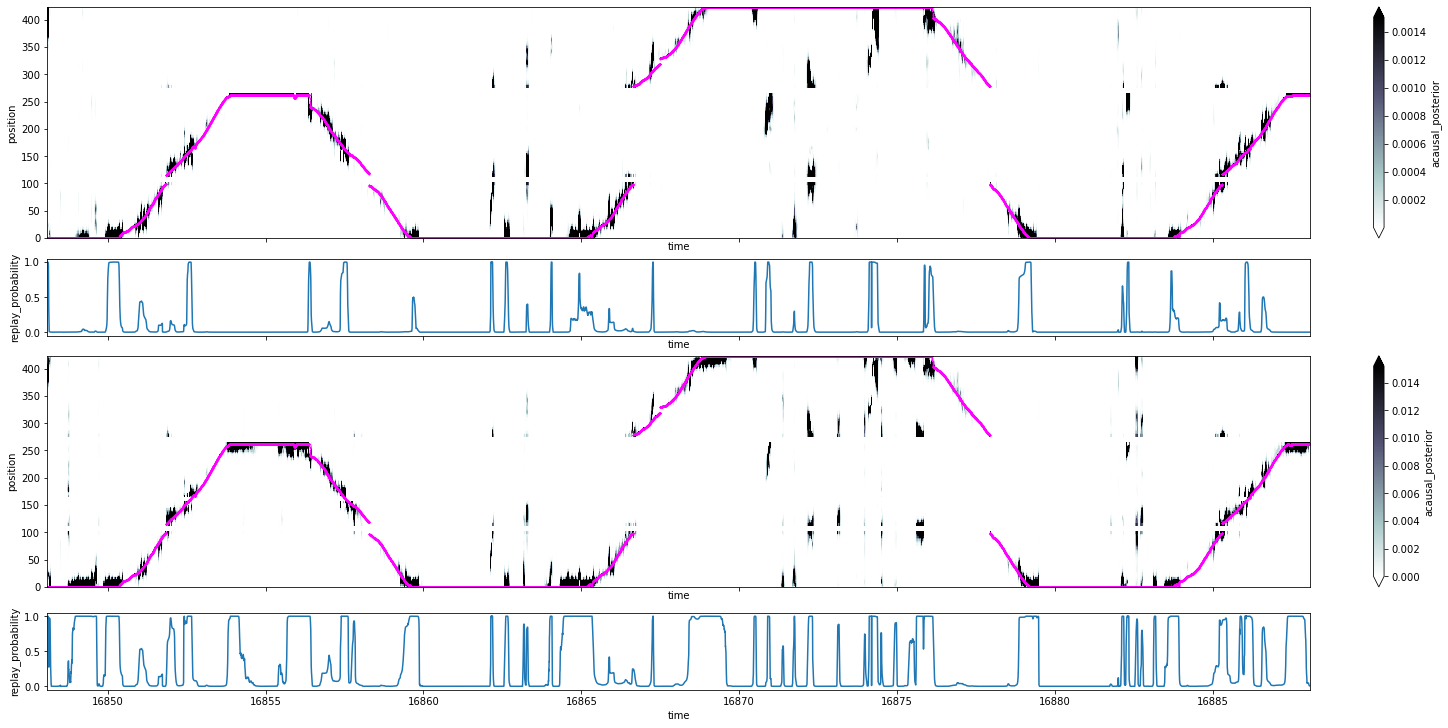

In [16]:
import matplotlib.pyplot as plt

time_slice = slice(240_000, 260_000)

fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1, 3, 1]})
detector_results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[0])
axes[0].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[1])

detector_results2.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[2])
axes[2].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results2.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[3])

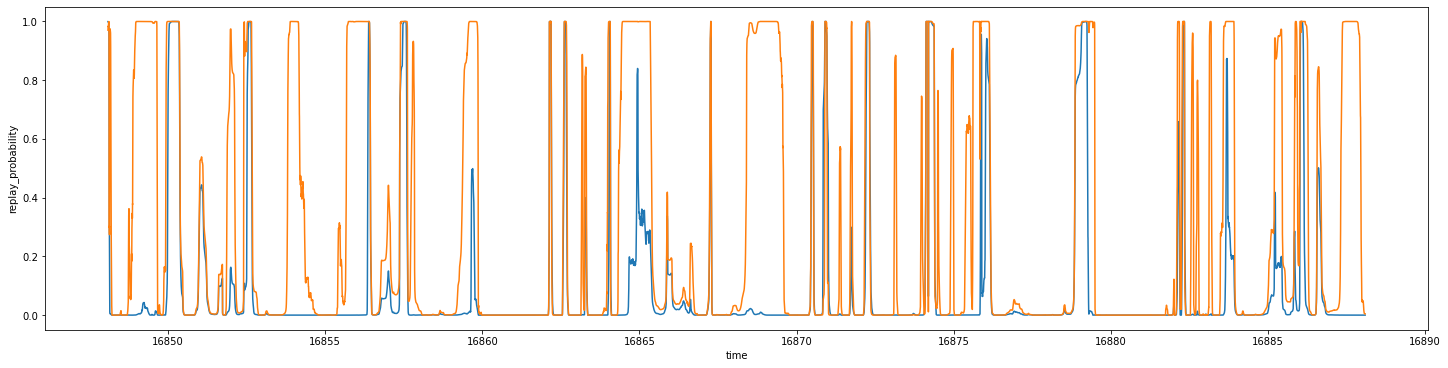

In [17]:
import matplotlib.pyplot as plt

time_slice = slice(240_000, 260_000)

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, constrained_layout=True)
detector_results.isel(time=time_slice).replay_probability.plot(x='time', ax=ax)
detector_results2.isel(time=time_slice).replay_probability.plot(x='time', ax=ax)

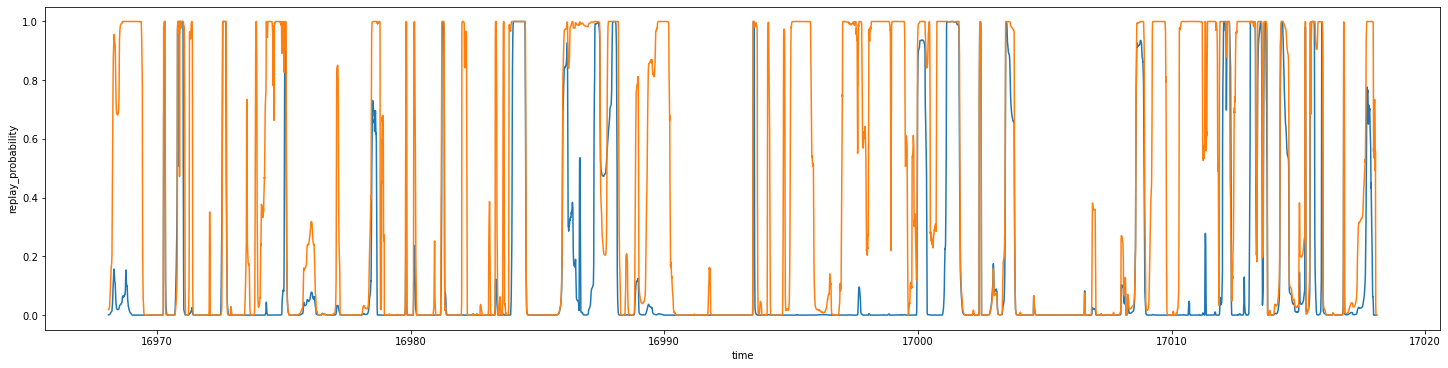

In [18]:
import matplotlib.pyplot as plt

time_slice = slice(300_000, 325_000)

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, constrained_layout=True)
detector_results.isel(time=time_slice).replay_probability.plot(x='time', ax=ax)
detector_results2.isel(time=time_slice).replay_probability.plot(x='time', ax=ax)

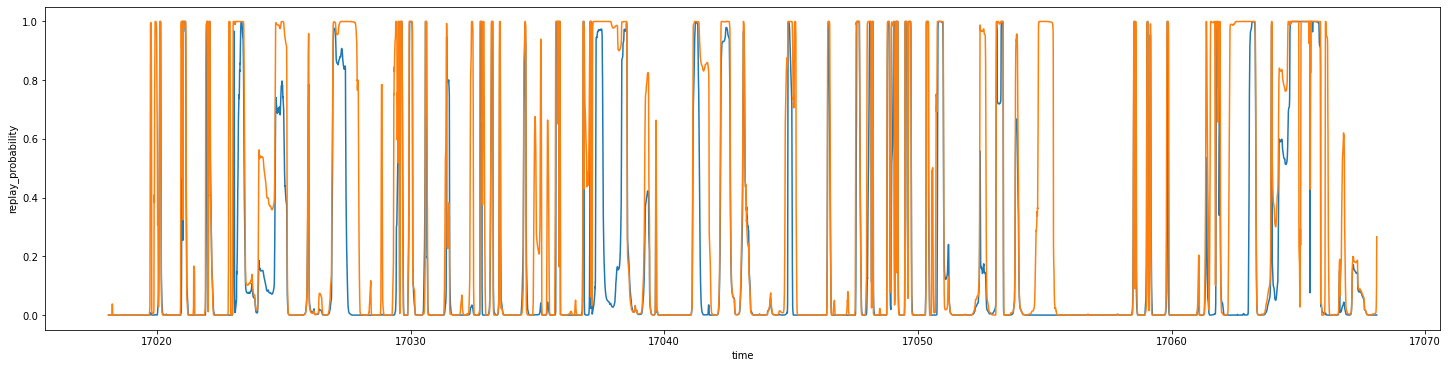

In [19]:
import matplotlib.pyplot as plt

time_slice = slice(325_000, 350_000)

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, constrained_layout=True)
detector_results.isel(time=time_slice).replay_probability.plot(x='time', ax=ax)
detector_results2.isel(time=time_slice).replay_probability.plot(x='time', ax=ax)

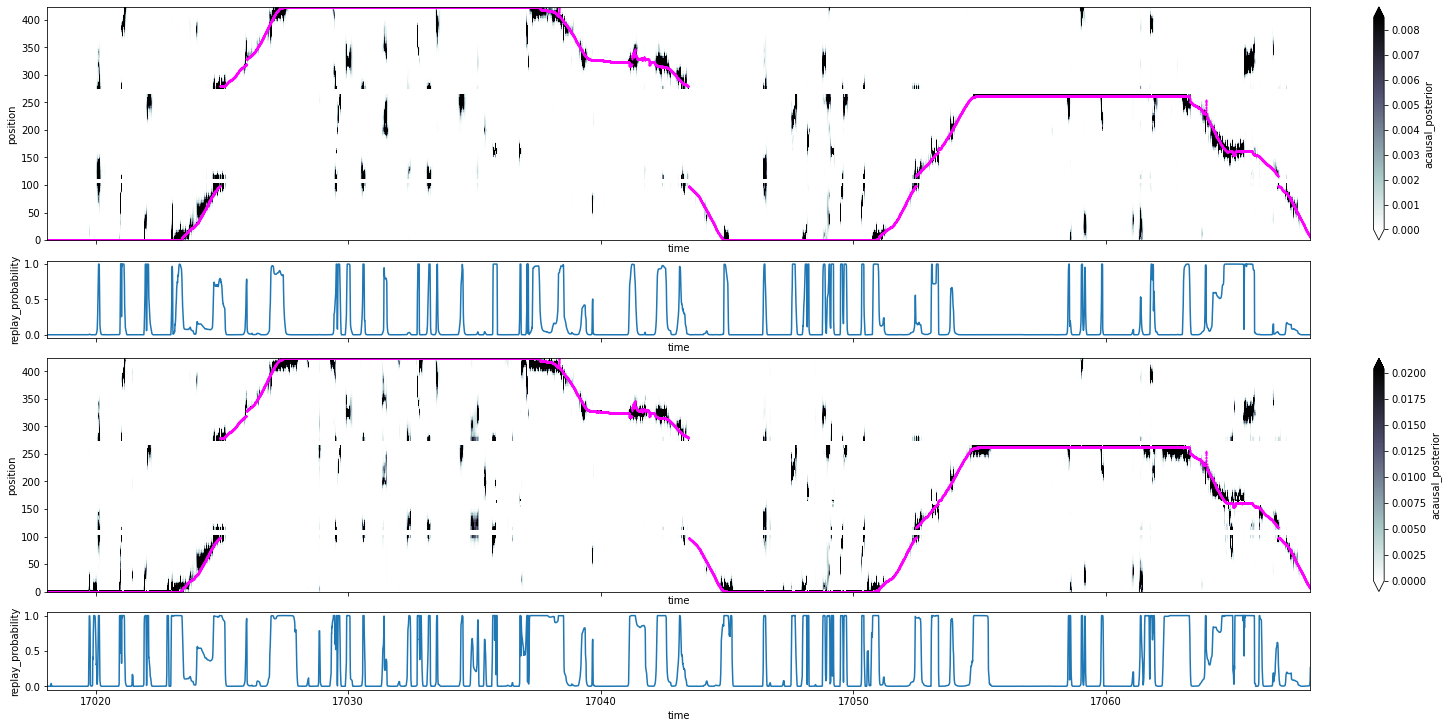

In [20]:
import matplotlib.pyplot as plt

time_slice = slice(325_000, 350_000)

fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1, 3, 1]})
detector_results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[0])
axes[0].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[1])

detector_results2.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', robust=True, cmap='bone_r', ax=axes[2])
axes[2].scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
                data['position_info'].iloc[time_slice].linear_position, color='magenta', s=0.5)
detector_results2.isel(time=time_slice).replay_probability.plot(x='time', ax=axes[3])

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]})
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    max_consensus = np.ceil(data['ripple_consensus_trace'].values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = data['ripple_consensus_trace'].loc[start_time:end_time]
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((0, max_consensus))
    axes[0].set_yticks((0, max_consensus))
    axes[0].set_ylabel("Ripple\nPower")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.argmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).replay_probability >= 0.8,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).replay_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

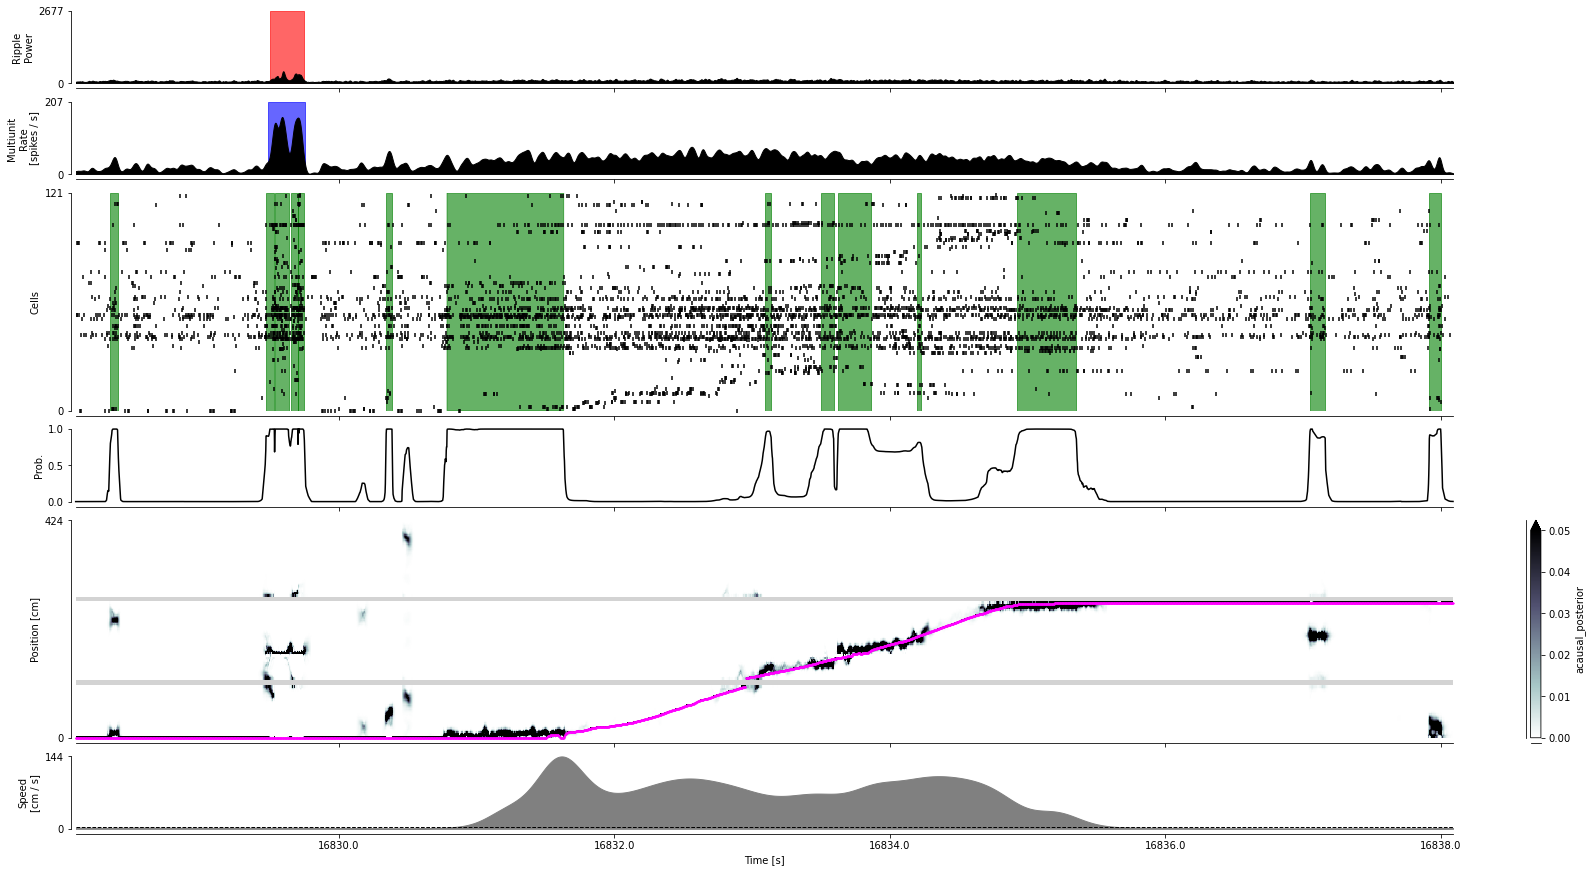

In [22]:
time_slice = slice(230_000, 235_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

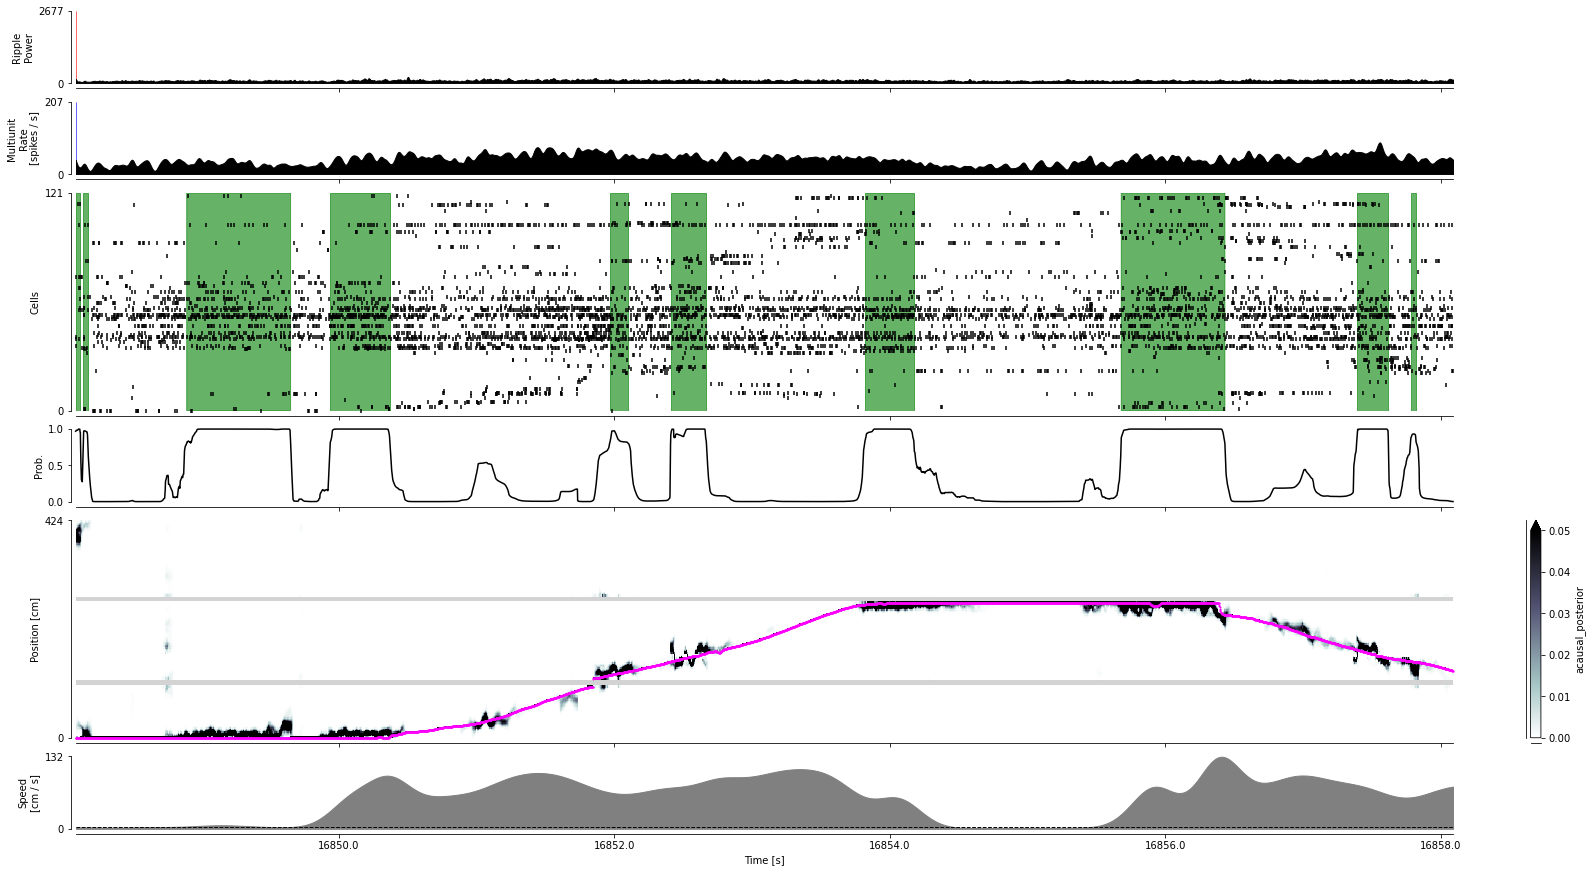

In [23]:
time_slice = slice(240_000, 245_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

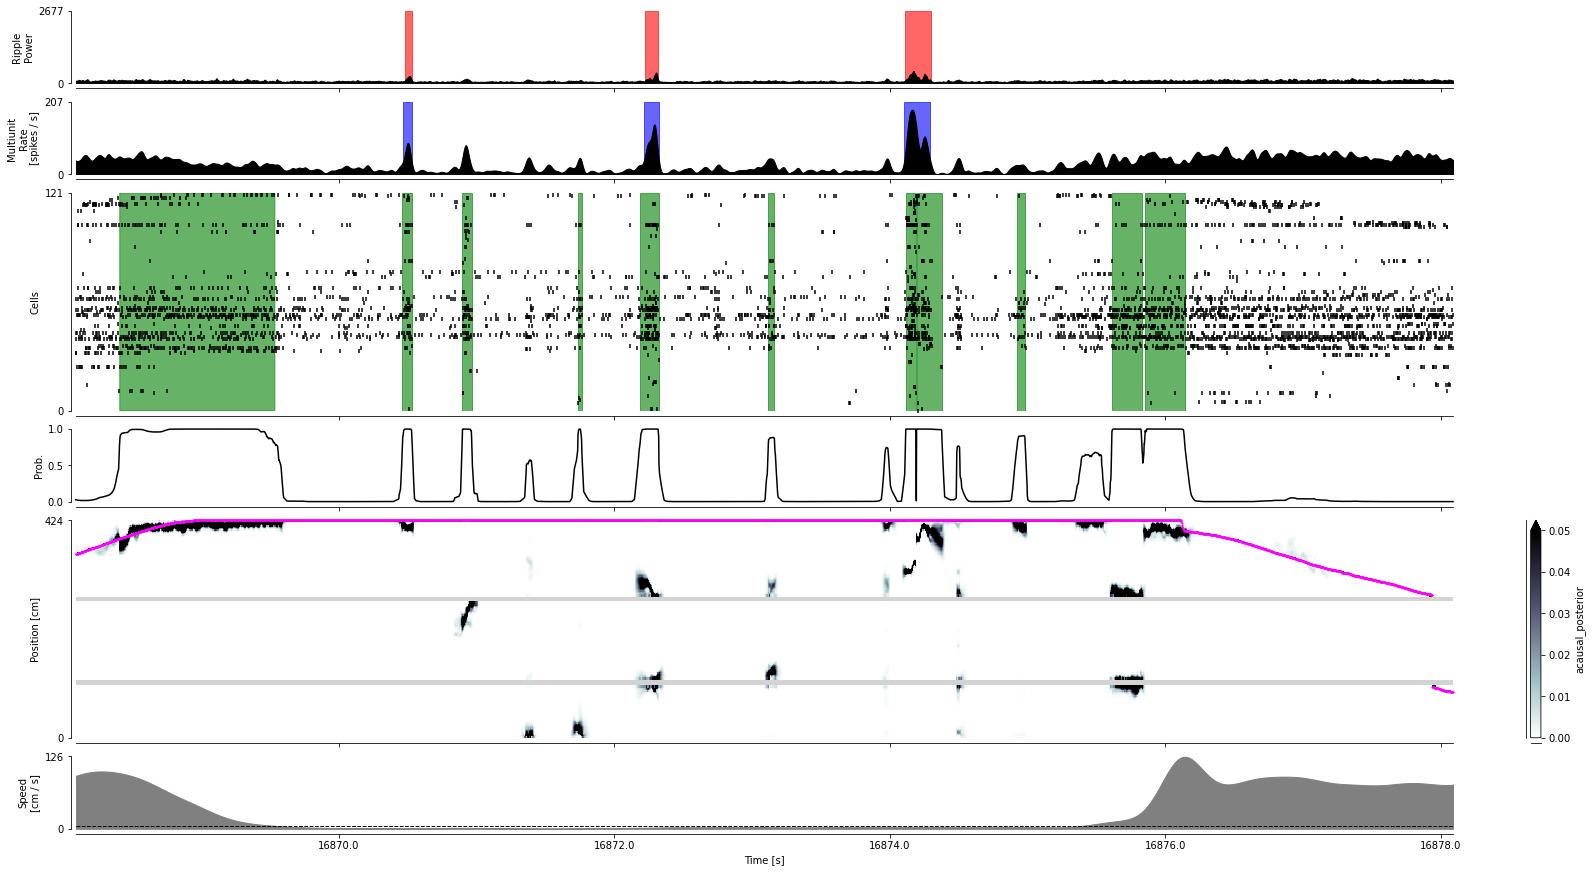

In [24]:
time_slice = slice(250_000, 255_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

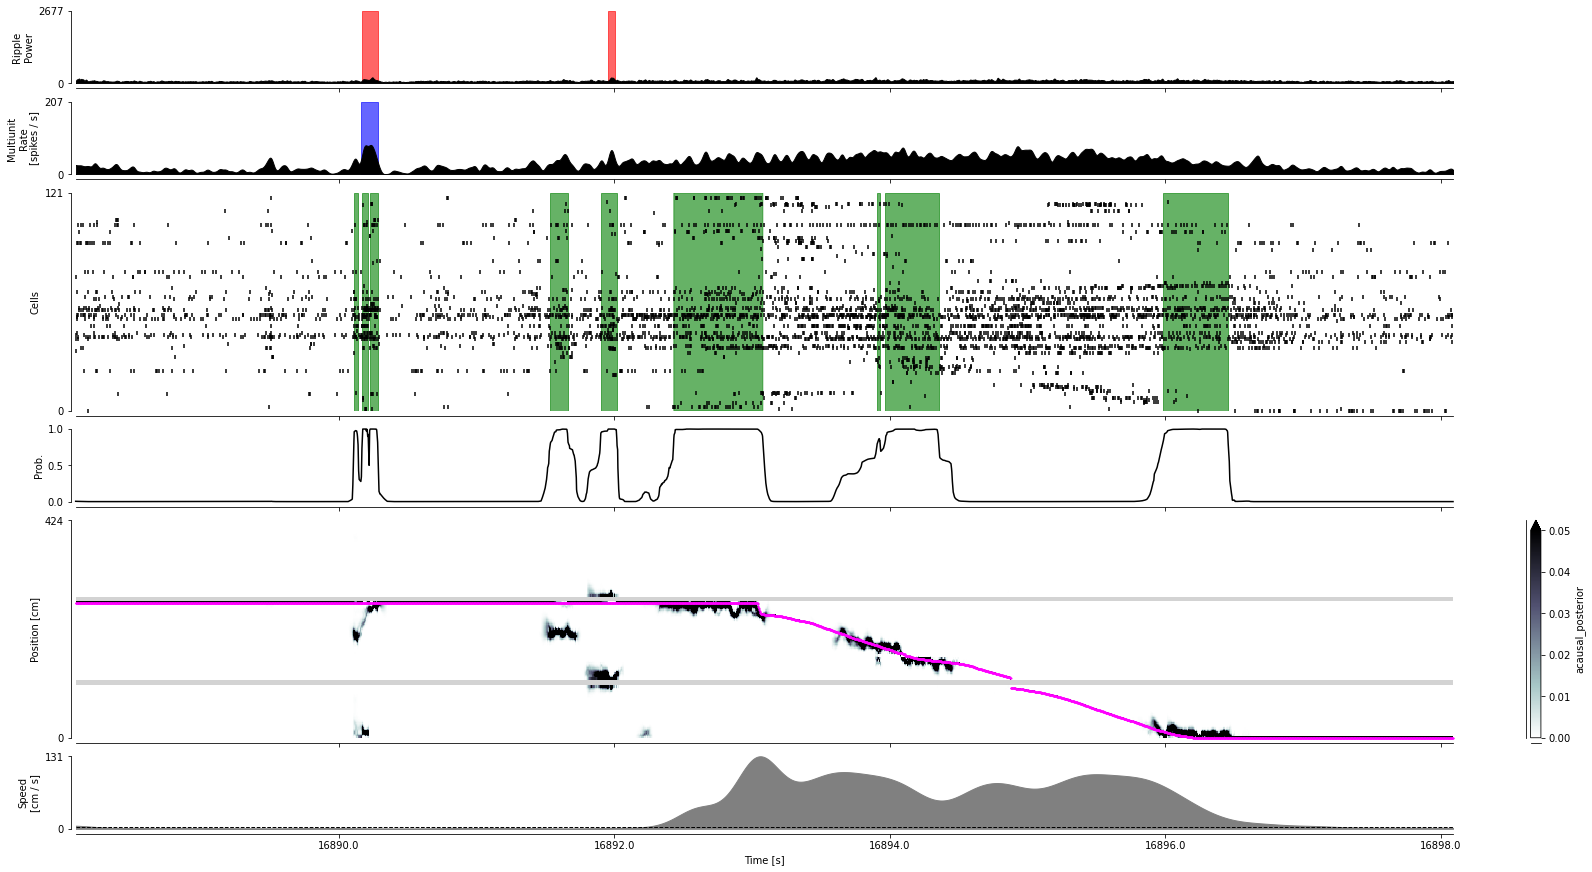

In [25]:
time_slice = slice(260_000, 265_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

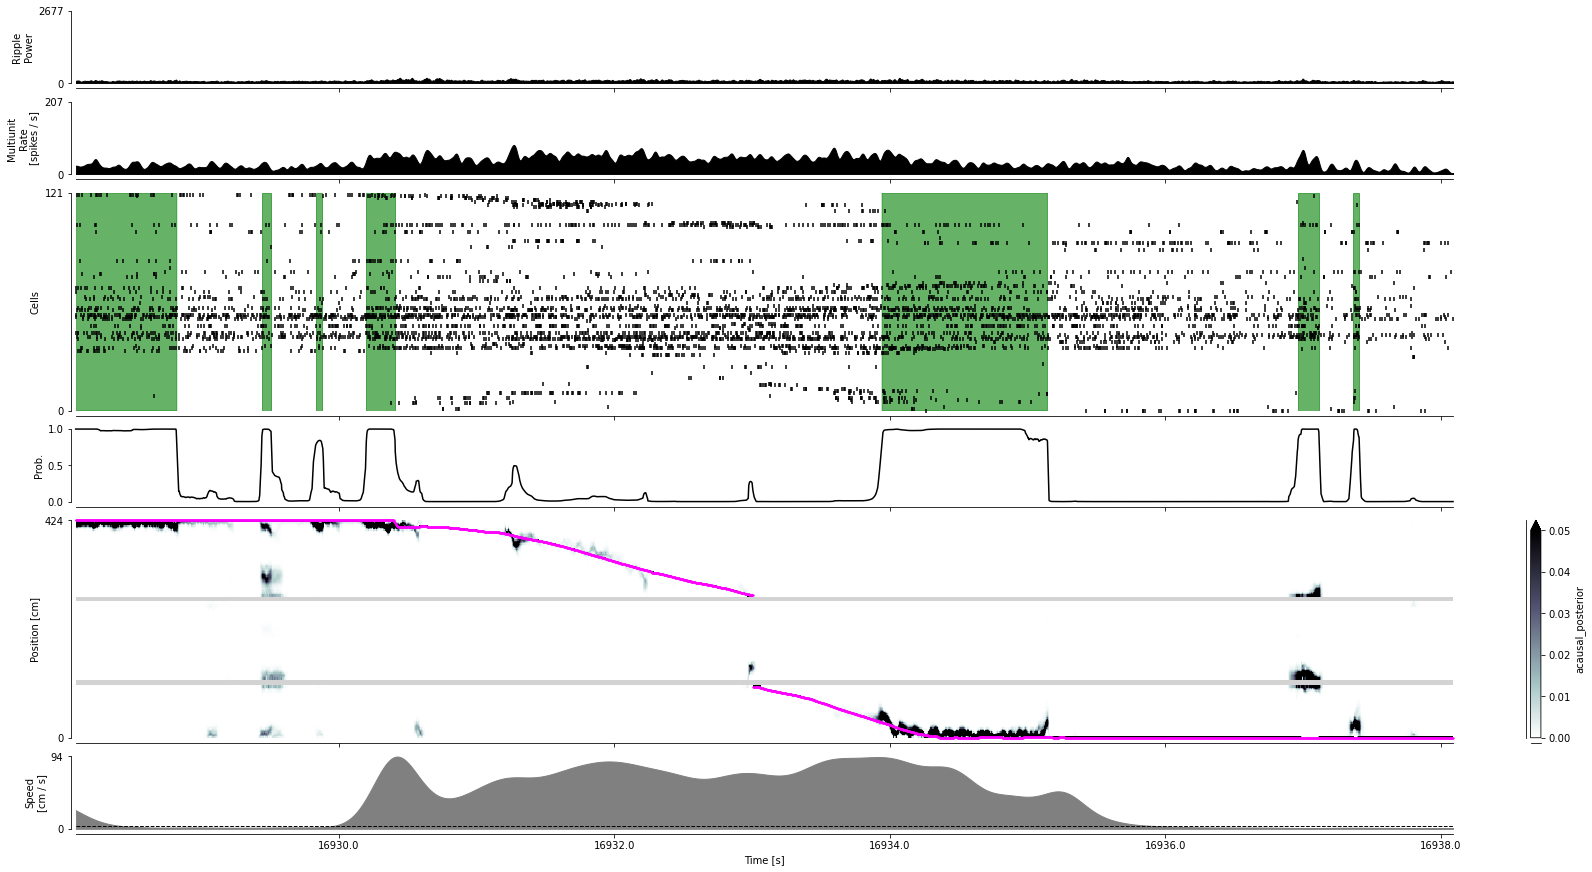

In [26]:
time_slice = slice(280_000, 285_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

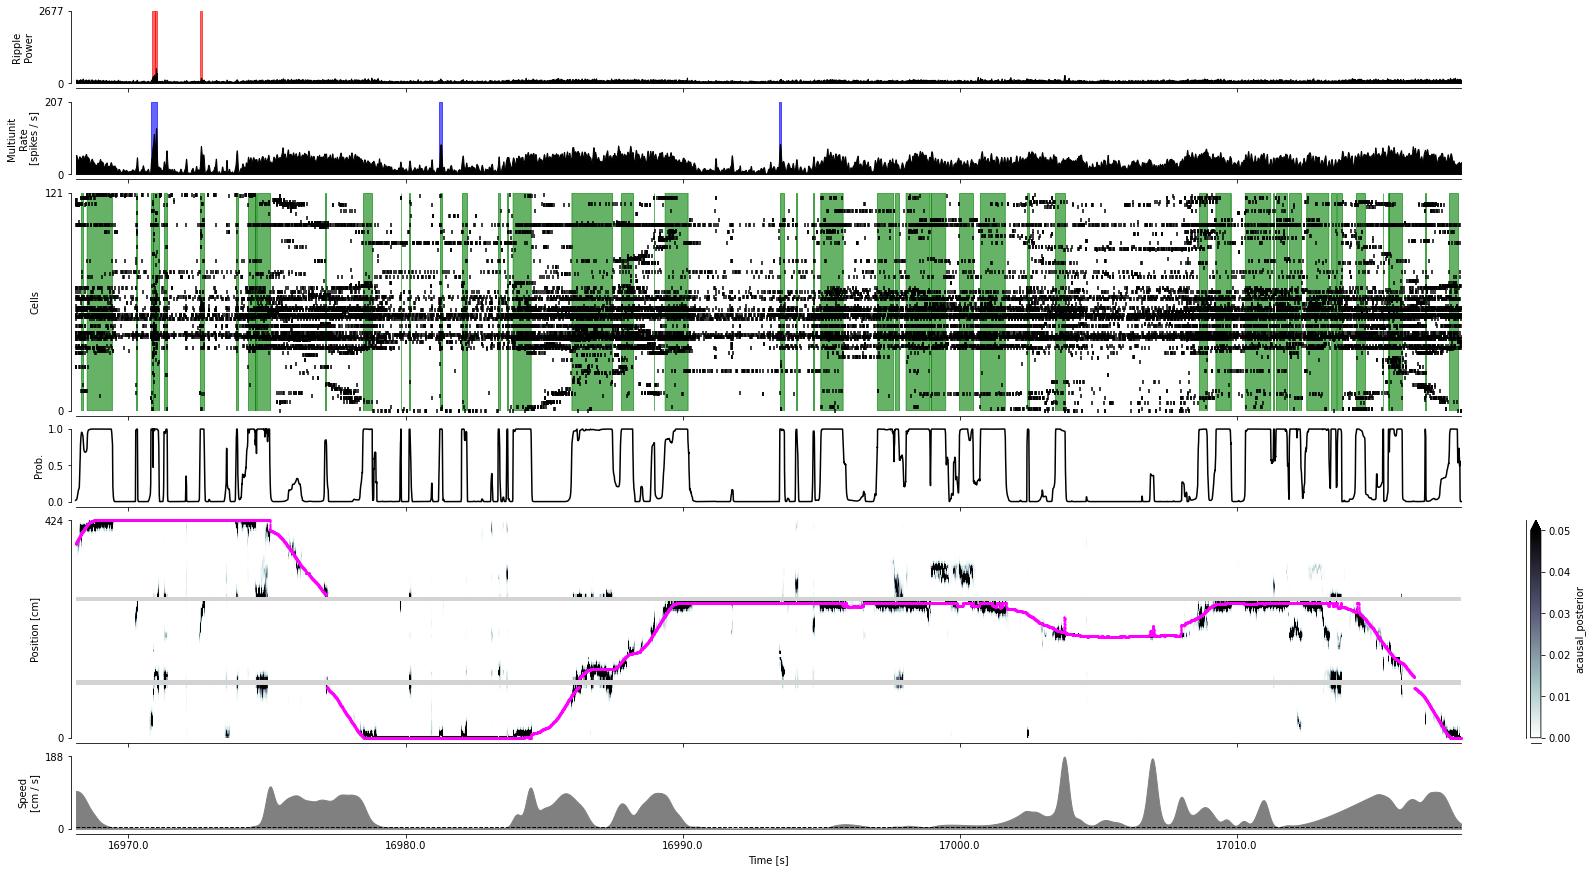

In [27]:
time_slice = slice(300_000, 325_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

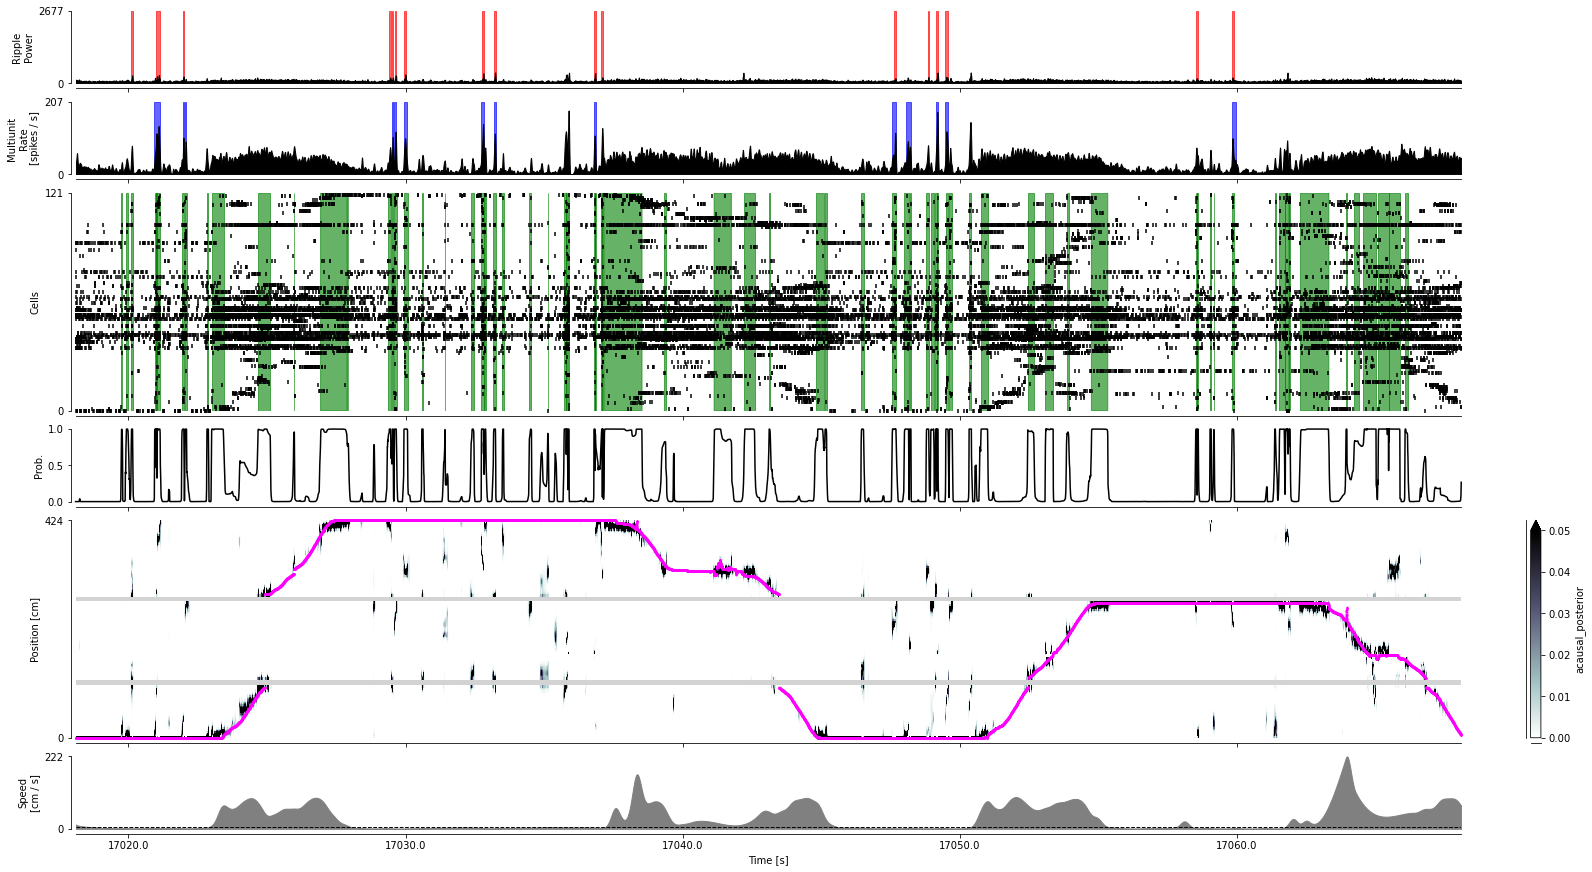

In [28]:
time_slice = slice(325_000, 350_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

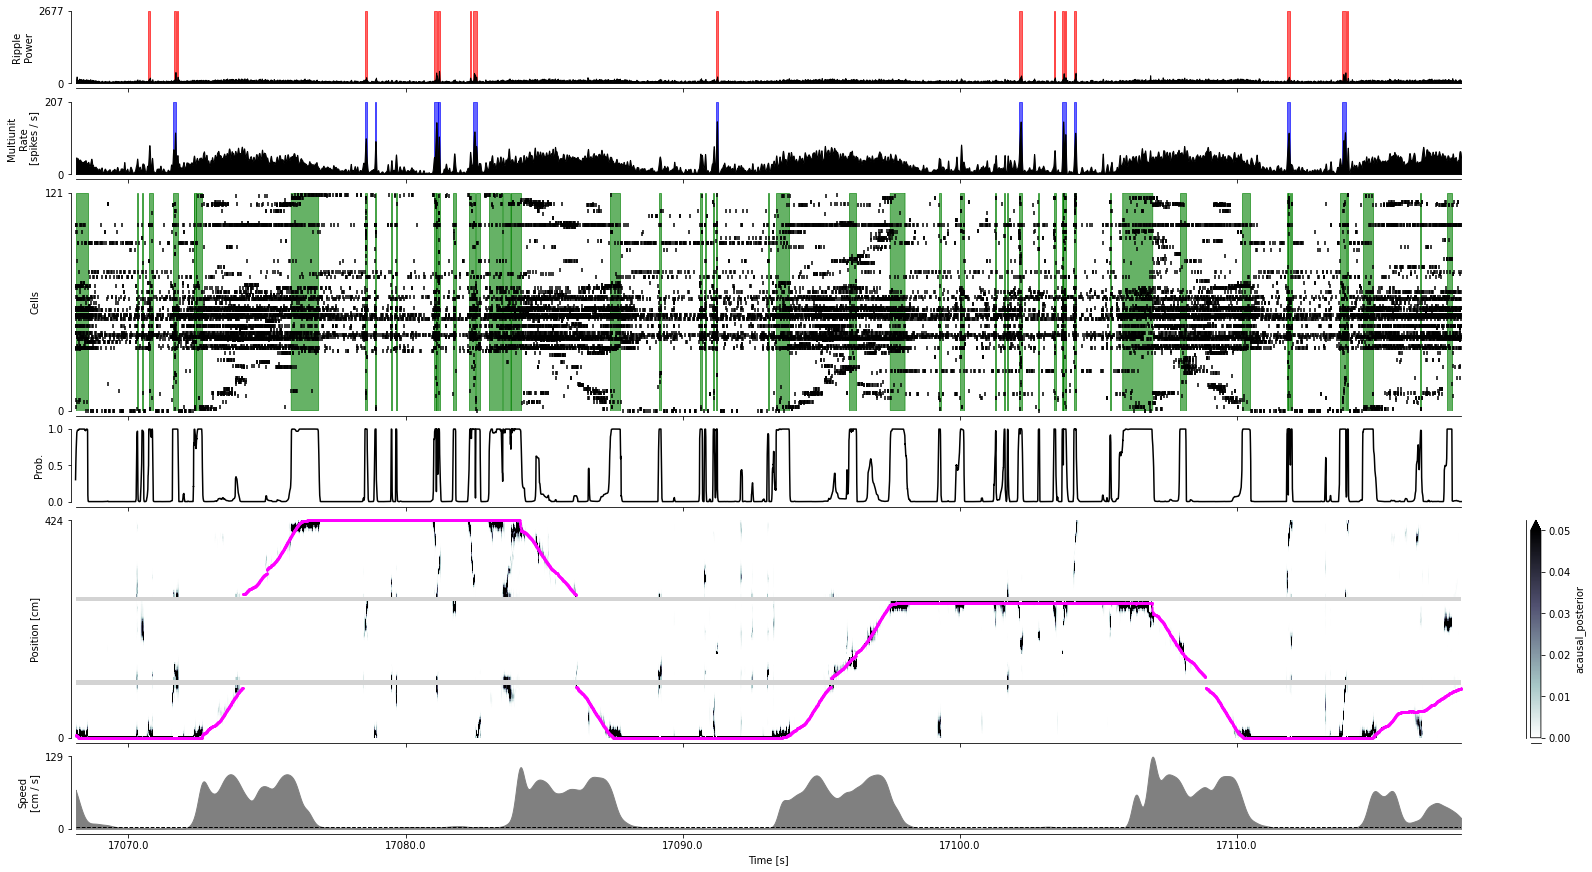

In [29]:
time_slice = slice(350_000, 375_000)
plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

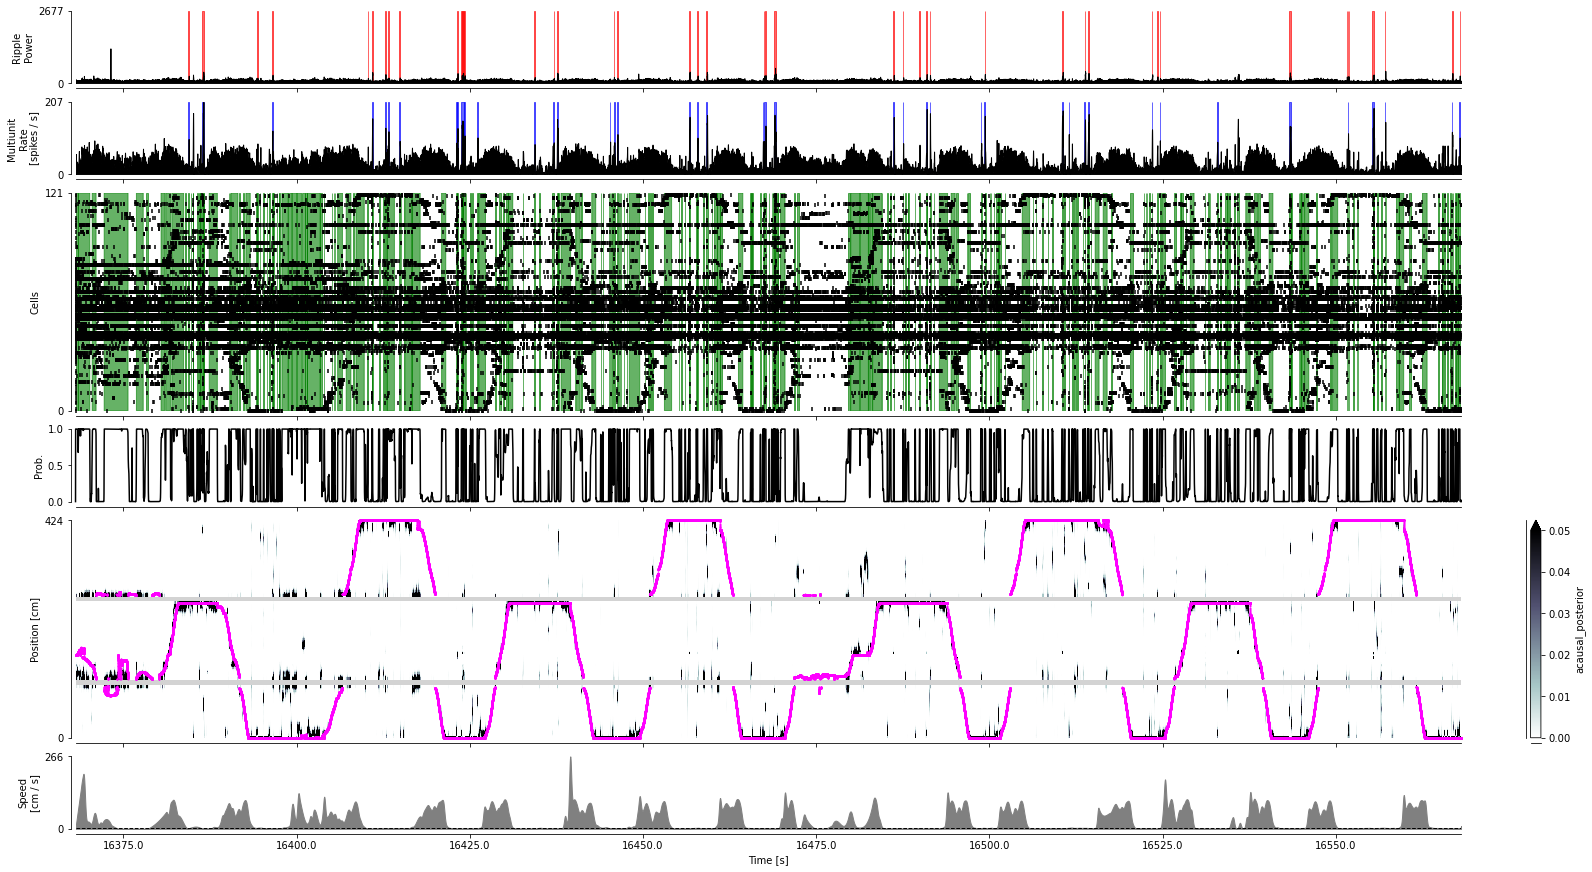

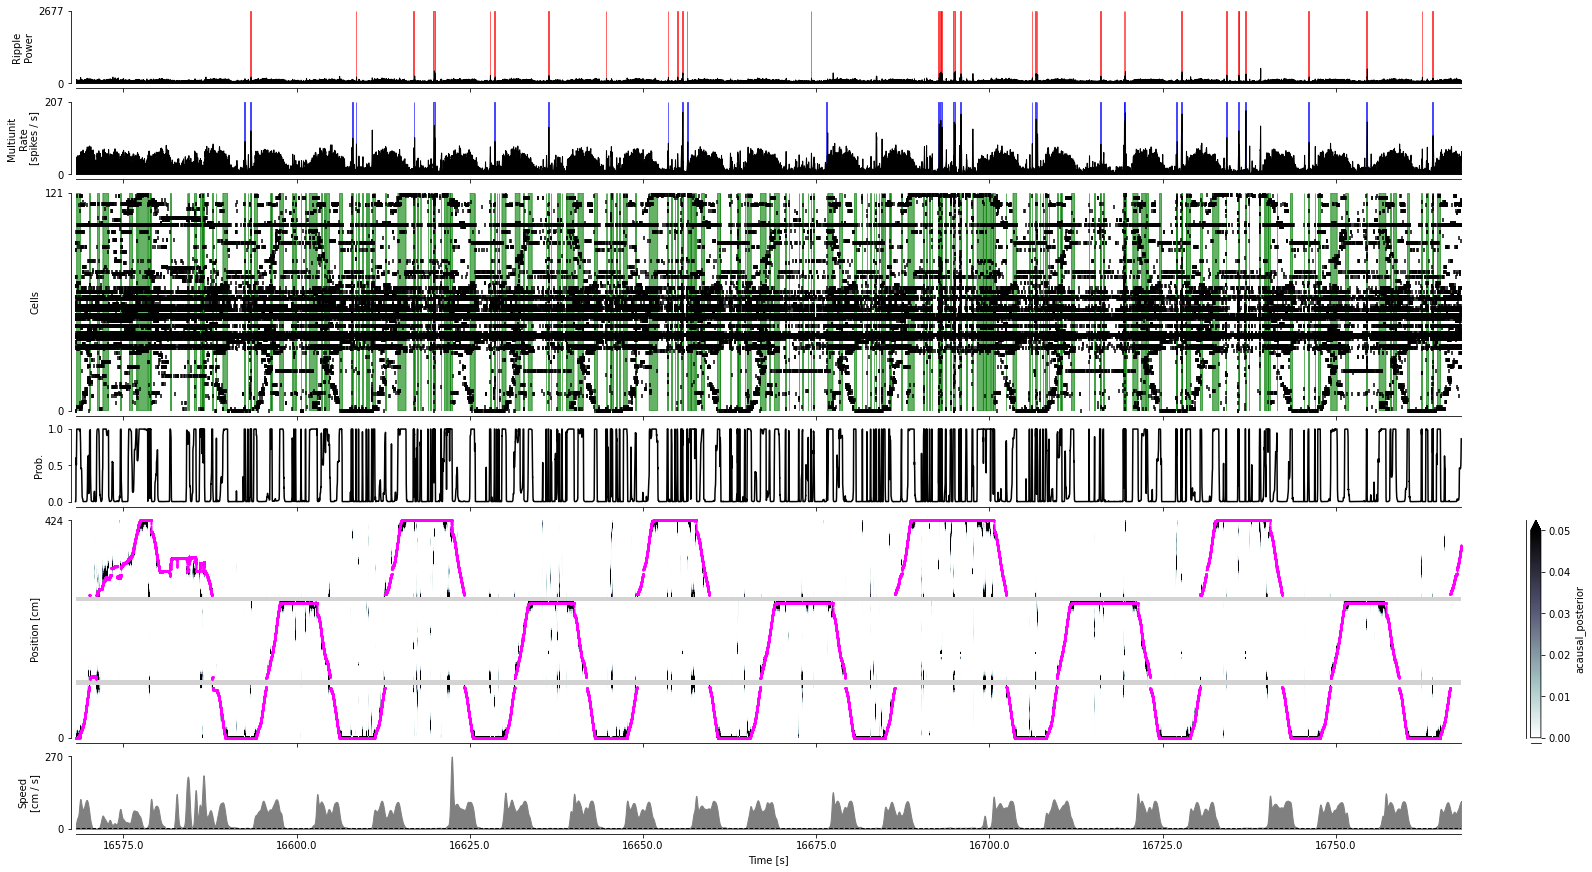

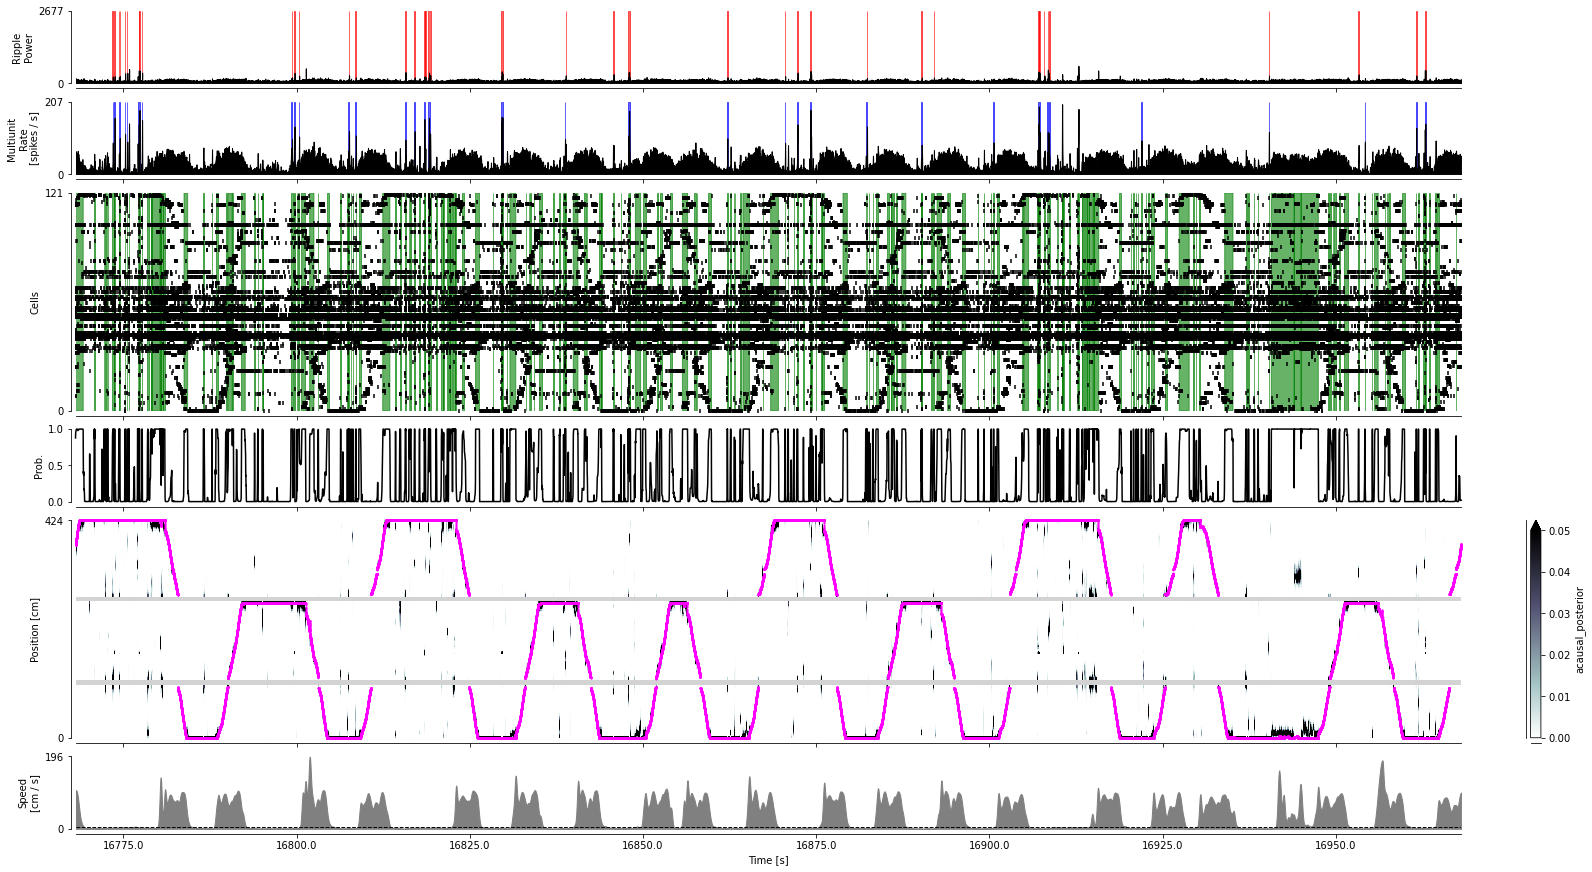

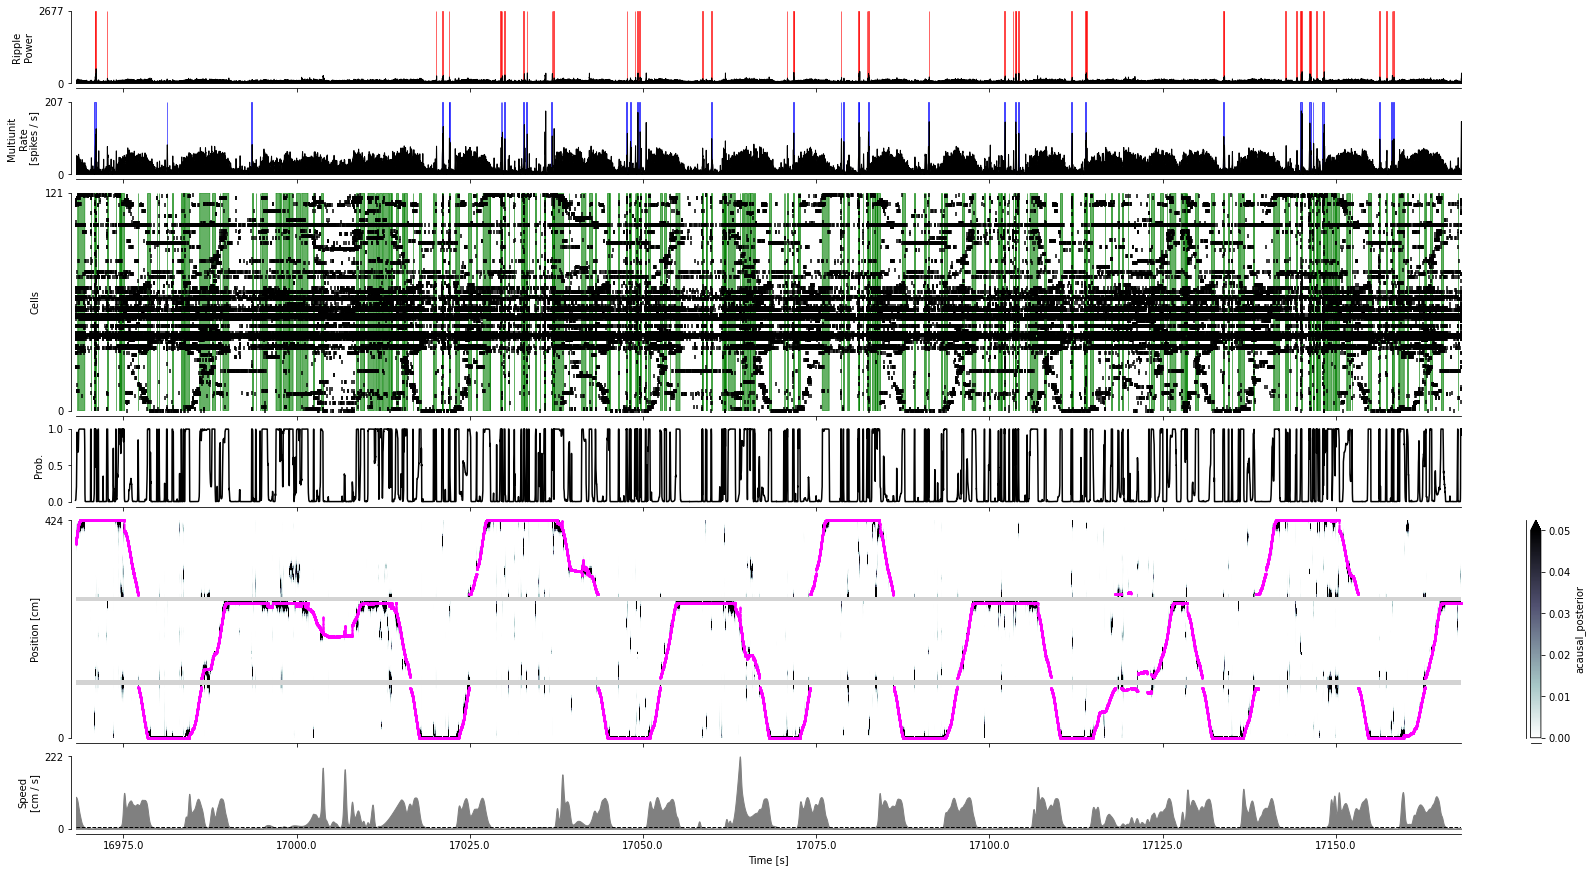

In [30]:
for start_ind in range(0, 400_000, 100_000):
    time_slice = slice(start_ind, start_ind + 100_000)
    plot_detector(time_slice, data, replay_detector2, detector_results2, figsize=(22, 12.0))

In [50]:
def refit_detector(detector_parameters, data, edge_order, edge_spacing, n_refits=1):

    replay_detector = ReplayDetector(**detector_parameters)
    logging.info(replay_detector)

    replay_detector.fit(
        is_ripple=data['is_ripple'],
        is_training=data['is_ripple'],
        speed=data['position_info'].nose_vel,
        position=data['position_info'].linear_position,
        spikes=data['spikes'],
        track_graph=data['track_graph'],
        center_well_id=0,
        edge_order=edge_order,
        edge_spacing=edge_spacing,
    )

    detector_results = replay_detector.predict(
        speed=data['position_info'].nose_vel,
        position=data['position_info'].linear_position,
        spikes=data['spikes'],
        time=data['position_info'].index / np.timedelta64(1, 's'),
        use_likelihoods=['spikes'],
        use_smoother=True)

    detector = [replay_detector]
    results = [detector_results]

    for fit_ind in range(n_refits):
        logging.info(f'refit #{fit_ind + 2}')
        replay_detector2 = ReplayDetector(**detector_parameters)
        replay_detector2.fit(
            is_ripple=results[-1].replay_probability > 0.8,
            is_training=results[-1].replay_probability <= 0.8,
            speed=data['position_info'].nose_vel,
            position=data['position_info'].linear_position,
            spikes=data['spikes'],
            track_graph=data['track_graph'],
            center_well_id=0,
            edge_order=EDGE_ORDER,
            edge_spacing=WTRACK_EDGE_SPACING,
        )
        detector_results2 = replay_detector2.predict(
            speed=data['position_info'].nose_vel,
            position=data['position_info'].linear_position,
            spikes=data['spikes'],
            time=data['position_info'].index / np.timedelta64(1, 's'),
            use_likelihoods=['spikes'],
            use_smoother=True)

        detector.append(replay_detector2)
        results.append(detector_results2)

    return detector, results

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [32]:
detector, results = refit_detector(detector_parameters, data, EDGE_ORDER, WTRACK_EDGE_SPACING, n_refits=10)

01-Nov-21 17:40:12 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mo...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spik

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 17:50:40 Fitting replay movement state transition...
01-Nov-21 17:50:40 Fitting replay state transition...
01-Nov-21 17:50:40 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 17:52:01 Finding causal replay probability and position...
01-Nov-21 17:52:10 Finding acausal replay probability and position...
01-Nov-21 17:52:41 refit #2
01-Nov-21 17:52:41 Fitting speed model...
01-Nov-21 17:52:42 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:11:29 Fitting replay movement state transition...
01-Nov-21 18:11:29 Fitting replay state transition...
01-Nov-21 18:11:29 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:12:49 Finding causal replay probability and position...
01-Nov-21 18:12:58 Finding acausal replay probability and position...
01-Nov-21 18:13:34 refit #3
01-Nov-21 18:13:34 Fitting speed model...
01-Nov-21 18:13:35 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:27:12 Fitting replay movement state transition...
01-Nov-21 18:27:13 Fitting replay state transition...
01-Nov-21 18:27:13 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:28:34 Finding causal replay probability and position...
01-Nov-21 18:28:42 Finding acausal replay probability and position...
01-Nov-21 18:29:15 refit #4
01-Nov-21 18:29:15 Fitting speed model...
01-Nov-21 18:29:16 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:40:28 Fitting replay movement state transition...
01-Nov-21 18:40:28 Fitting replay state transition...
01-Nov-21 18:40:28 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:41:48 Finding causal replay probability and position...
01-Nov-21 18:41:57 Finding acausal replay probability and position...
01-Nov-21 18:42:31 refit #5
01-Nov-21 18:42:31 Fitting speed model...
01-Nov-21 18:42:33 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:52:50 Fitting replay movement state transition...
01-Nov-21 18:52:50 Fitting replay state transition...
01-Nov-21 18:52:50 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 18:54:10 Finding causal replay probability and position...
01-Nov-21 18:54:18 Finding acausal replay probability and position...
01-Nov-21 18:54:50 refit #6
01-Nov-21 18:54:51 Fitting speed model...
01-Nov-21 18:54:52 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:04:06 Fitting replay movement state transition...
01-Nov-21 19:04:06 Fitting replay state transition...
01-Nov-21 19:04:06 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:05:24 Finding causal replay probability and position...
01-Nov-21 19:05:33 Finding acausal replay probability and position...
01-Nov-21 19:06:11 refit #7
01-Nov-21 19:06:11 Fitting speed model...
01-Nov-21 19:06:12 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:15:00 Fitting replay movement state transition...
01-Nov-21 19:15:01 Fitting replay state transition...
01-Nov-21 19:15:01 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:16:20 Finding causal replay probability and position...
01-Nov-21 19:16:28 Finding acausal replay probability and position...
01-Nov-21 19:16:56 refit #8
01-Nov-21 19:16:56 Fitting speed model...
01-Nov-21 19:16:57 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:25:21 Fitting replay movement state transition...
01-Nov-21 19:25:21 Fitting replay state transition...
01-Nov-21 19:25:21 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:26:44 Finding causal replay probability and position...
01-Nov-21 19:26:53 Finding acausal replay probability and position...
01-Nov-21 19:27:26 refit #9
01-Nov-21 19:27:26 Fitting speed model...
01-Nov-21 19:27:28 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:35:42 Fitting replay movement state transition...
01-Nov-21 19:35:43 Fitting replay state transition...
01-Nov-21 19:35:43 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:37:03 Finding causal replay probability and position...
01-Nov-21 19:37:11 Finding acausal replay probability and position...
01-Nov-21 19:37:39 refit #10
01-Nov-21 19:37:40 Fitting speed model...
01-Nov-21 19:37:41 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:45:45 Fitting replay movement state transition...
01-Nov-21 19:45:46 Fitting replay state transition...
01-Nov-21 19:45:46 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:47:06 Finding causal replay probability and position...
01-Nov-21 19:47:15 Finding acausal replay probability and position...
01-Nov-21 19:47:48 refit #11
01-Nov-21 19:47:48 Fitting speed model...
01-Nov-21 19:47:50 Fitting spiking model...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:55:38 Fitting replay movement state transition...
01-Nov-21 19:55:38 Fitting replay state transition...
01-Nov-21 19:55:38 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

01-Nov-21 19:56:56 Finding causal replay probability and position...
01-Nov-21 19:57:05 Finding acausal replay probability and position...


In [49]:
from ipywidgets import interact

@interact(refit_ind=(0, 9))
def plot_slice(refit_ind=0):
    time_slice = slice(100_000, 150_000)
    plot_detector(time_slice, data, detector[refit_ind], results[refit_ind], figsize=(22, 12.0))

interactive(children=(IntSlider(value=0, description='refit_ind', max=9), Output()), _dom_classes=('widget-int…